In [1]:
import os
import sys
from pathlib import Path
import json
os.environ['MMWHS_CACHE_PATH'] = str(Path('.', '.cache'))

from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars('*'))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp

from tqdm import tqdm
import wandb
import nibabel as nib

from slice_inflate.datasets.mmwhs_dataset import MMWHSDataset, load_data, extract_2d_data
from slice_inflate.utils.common_utils import DotDict, get_script_dir, in_notebook
from slice_inflate.utils.torch_utils import reset_determinism, ensure_dense, \
    get_batch_dice_over_all, get_batch_score_per_label, save_model, \
    reduce_label_scores_epoch, get_test_func_all_parameters_updated
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from slice_inflate.datasets.align_mmwhs import cut_slice
from slice_inflate.utils.log_utils import get_global_idx, log_label_metrics, log_oa_metrics
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from slice_inflate.losses.dice_loss import DC_and_CE_loss

from mdl_seg_class.metrics import dice3d, hausdorff3d
import numpy as np

from slice_inflate.models.generic_UNet_opt_skip_connections import Generic_UNet
import dill

import einops as eo

THIS_SCRIPT_DIR = get_script_dir()

PROJECT_NAME = "slice_inflate"

training_dataset, test_dataset = None, None
test_all_parameters_updated = get_test_func_all_parameters_updated()


### Recommended gpus on this machine (descending order) ###
  ID  Card name                     Util    Mem free  Cuda             User(s)
----  --------------------------  ------  ----------  ---------------  ---------
   2  NVIDIA GeForce GTX 1080 Ti     0 %   11176 MiB  11.4(470.63.01)
   3  NVIDIA GeForce GTX 1080 Ti     0 %   11176 MiB  11.4(470.63.01)
   0  NVIDIA GeForce GTX 1080 Ti     0 %    7852 MiB  11.4(470.63.01)  graf
   1  NVIDIA GeForce GTX 1080 Ti     0 %     465 MiB  11.4(470.63.01)  graf

Will apply following mapping

  ID  Card name                       torch
----  --------------------------  --  -------
   2  NVIDIA GeForce GTX 1080 Ti  ->  cuda:0


Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issu

In [2]:

with open(Path(THIS_SCRIPT_DIR, 'config_dict.json'), 'r') as f:
    config_dict = DotDict(json.load(f))

def prepare_data(config):
    training_dataset = MMWHSDataset(
        config.data_base_path,
        state=config.state,
        load_func=load_data,
        extract_slice_func=extract_2d_data,
        modality=config.modality,
        do_align_global=True,
        do_resample=False, # Prior to cropping, resample image?
        crop_3d_region=None, # Crop or pad the images to these dimensions
        fov_mm=config.fov_mm,
        fov_vox=config.fov_vox,
        crop_around_3d_label_center=config.crop_around_3d_label_center,
        pre_interpolation_factor=1., # When getting the data, resize the data by this factor
        ensure_labeled_pairs=True, # Only use fully labelled images (segmentation label available)
        use_2d_normal_to=config.use_2d_normal_to, # Use 2D slices cut normal to D,H,>W< dimensions
        crop_around_2d_label_center=config.crop_around_2d_label_center,
        max_load_3d_num=config.max_load_3d_num,

        augment_angle_std=5,

        device=config.device,
        debug=config.debug
    )

    return training_dataset

In [3]:

run_test_once_only = not (config_dict.test_only_and_output_to in ["", None])

if training_dataset is None:
    train_config = DotDict(config_dict.copy())
    if run_test_once_only:
        train_config['state'] = 'empty'
    training_dataset = prepare_data(train_config)

if test_dataset is None:
    test_config = DotDict(config_dict.copy())
    test_config['state'] = 'test'
    test_dataset = prepare_data(test_config)

Loading MMWHS train images and labels... (['mr', 'ct'])


30 images, 30 labels: 100%|██████████| 60/60 [00:03<00:00, 15.67it/s]


Postprocessing 3D volumes
Removed 0 3D images in postprocessing
Equal image and label numbers: True (30)
Data import finished.
Dataloader will yield 3D samples
Loading MMWHS test images and labels... (['mr', 'ct'])


10 images, 10 labels: 100%|██████████| 20/20 [00:01<00:00, 17.55it/s]


Postprocessing 3D volumes
Removed 0 3D images in postprocessing
Equal image and label numbers: True (10)
Data import finished.
Dataloader will yield 3D samples


do_augment True


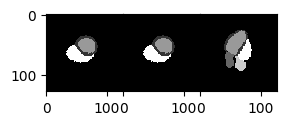

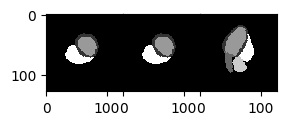

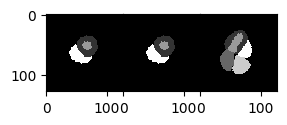

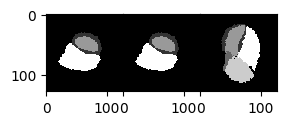

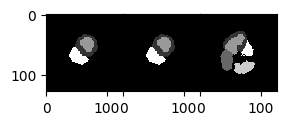

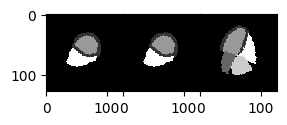

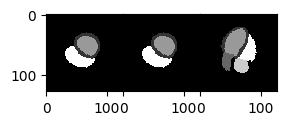

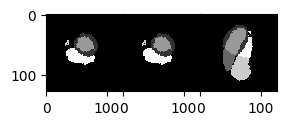

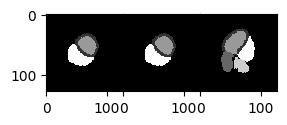

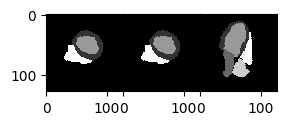

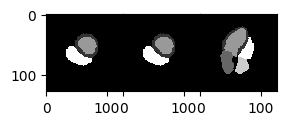

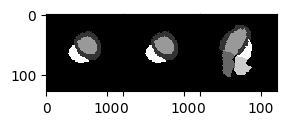

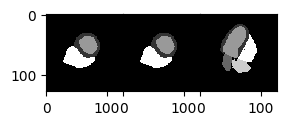

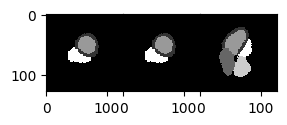

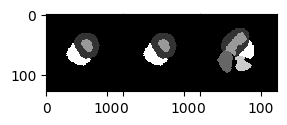

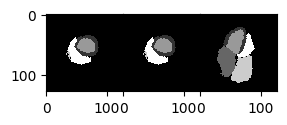

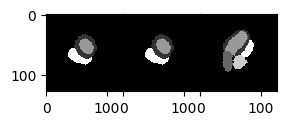

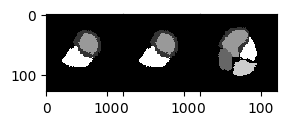

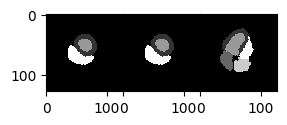

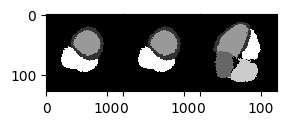

In [8]:
if True:
    training_dataset.train(augment=True)
    training_dataset.self_attributes['augment_angle_std'] = 1
    print("do_augment", training_dataset.do_augment)
    for sample in [training_dataset[idx] for idx in range(20)]:
        fig = plt.figure(figsize=(16., 1.))

        show_row = [
            # cut_slice(sample['image']),
            cut_slice(sample['label'].unsqueeze(0)).argmax(1).squeeze(),

            # sample['sa_image_slc'],
            sample['sa_label_slc'].unsqueeze(0).argmax(1).squeeze(),

            # sample['hla_image_slc'],
            sample['hla_label_slc'].unsqueeze(0).argmax(1).squeeze(),
        ]

        show_row = [sh.cpu() for sh in show_row]

        grid = ImageGrid(fig, 111,  # similar to subplot(111)
            nrows_ncols=(1, len(show_row)),  # creates 2x2 grid of axes
            axes_pad=0.0,  # pad between axes in inch.
        )

        for ax, im in zip(grid, show_row):
            ax.imshow(im, cmap='gray', interpolation='none')

        plt.show()

do_augment True


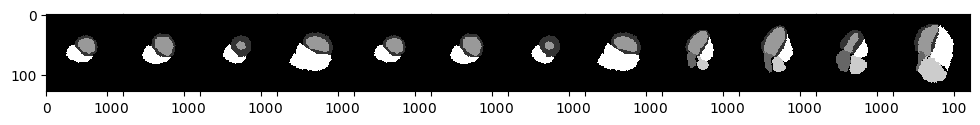

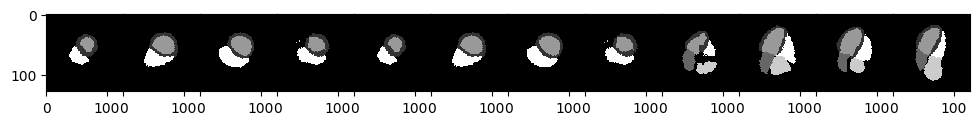

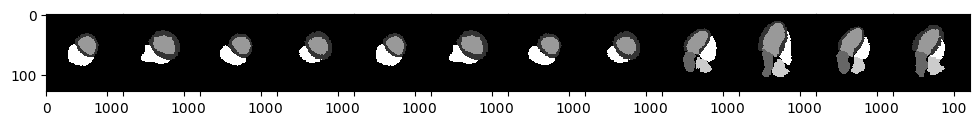

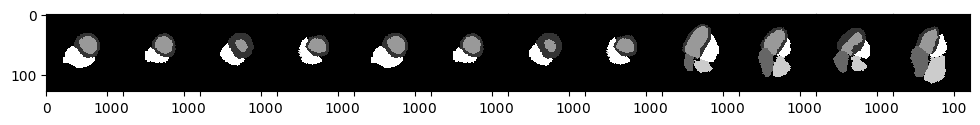

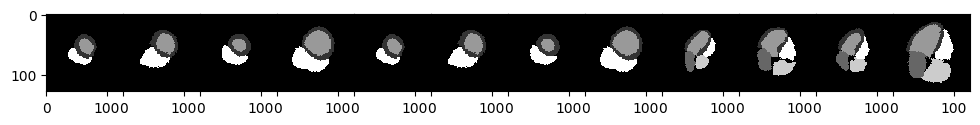

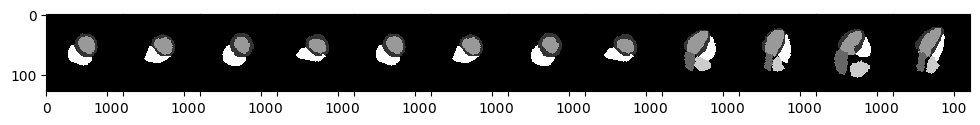

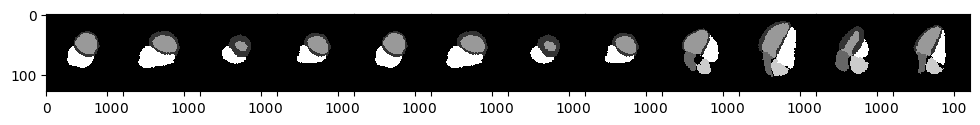

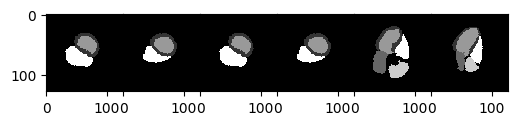

In [9]:
if True:
    training_dataset.train(augment=True)
    training_dataset.self_attributes['augment_angle_std'] = 1
    print("do_augment", training_dataset.do_augment)

    train_dataloader = DataLoader(training_dataset, batch_size=config_dict.batch_size,
        pin_memory=False, drop_last=False,
        collate_fn=training_dataset.get_efficient_augmentation_collate_fn()
    )
    training_dataset.set_augment_at_collate(True)

    for batch in train_dataloader:
        fig = plt.figure(figsize=(16., 1.))

        show_row = \
            [sh for sh in cut_slice(batch['label']).argmax(1).squeeze()] + \
            [sh for sh in batch['sa_label_slc'].argmax(1).squeeze()] + \
            [sh for sh in batch['hla_label_slc'].argmax(1).squeeze()]
        
        show_row = [sh.cpu() for sh in show_row]
        
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
            nrows_ncols=(1, len(show_row)),  # creates 2x2 grid of axes
            axes_pad=0.0,  # pad between axes in inch.
        )

        for ax, im in zip(grid, show_row):
            ax.imshow(im, cmap='gray', interpolation='none')

        plt.show()

In [ ]:
if False:
    training_dataset.train()

    training_dataset.self_attributes['augment_angle_std'] = 5
    print("do_augment", training_dataset.do_augment)
    for sample_idx in range(20):
        lbl, sa_label, hla_label = torch.zeros(128,128), torch.zeros(128,128), torch.zeros(128,128)
        for augment_idx in range(15):
            sample = training_dataset[sample_idx]
            nib.save(nib.Nifti1Image(sample['label'].cpu().numpy(), affine=torch.eye(4).numpy()), f'out{sample_idx}.nii.gz')
            lbl += cut_slice(sample['label']).cpu()
            sa_label += sample['sa_label_slc'].cpu()
            hla_label += sample['hla_label_slc'].cpu()

        fig = plt.figure(figsize=(16., 4.))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
            nrows_ncols=(1, 3),  # creates 2x2 grid of axes
            axes_pad=0.0,  # pad between axes in inch.
        )

        show_row = [
            lbl, sa_label, hla_label
        ]

        for ax, im in zip(grid, show_row):
            ax.imshow(im, cmap='magma', interpolation='none')

        plt.show()

In [ ]:
if False:
    training_dataset.train(augment=False)
    training_dataset.self_attributes['augment_angle_std'] = 2
    print(training_dataset.do_augment)

    lbl, sa_label, hla_label = torch.zeros(128,128), torch.zeros(128,128), torch.zeros(128,128)
    for tr_idx in range(len(training_dataset)):
        sample = training_dataset[tr_idx]

        lbl += cut_slice(sample['label']).cpu()
        sa_label += sample['sa_label_slc'].cpu()
        hla_label += sample['hla_label_slc'].cpu()

    fig = plt.figure(figsize=(16., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
        nrows_ncols=(1, 3),  # creates 2x2 grid of axes
        axes_pad=0.0,  # pad between axes in inch.
    )

    show_row = [
        lbl, sa_label, hla_label
    ]

    for ax, im in zip(grid, show_row):
        ax.imshow(im, cmap='magma', interpolation='none')

    plt.show()

In [ ]:
class BlendowskiAE(torch.nn.Module):

    class ConvBlock(torch.nn.Module):
        def __init__(self, in_channels: int, out_channels_list: list, strides_list: list, kernels_list:list=None, paddings_list:list=None):
            super().__init__()

            ops = []
            in_channels = [in_channels] + out_channels_list[:-1]
            if kernels_list is None:
                kernels_list = [3] * len(out_channels_list)
            if paddings_list is None:
                paddings_list = [1] * len(out_channels_list)

            for op_idx in range(len(out_channels_list)):
                ops.append(torch.nn.Conv3d(
                    in_channels[op_idx],
                    out_channels_list[op_idx],
                    kernel_size=kernels_list[op_idx],
                    stride=strides_list[op_idx],
                    padding=paddings_list[op_idx]
                ))
                ops.append(torch.nn.BatchNorm3d(out_channels_list[op_idx]))
                ops.append(torch.nn.LeakyReLU())

            self.block = torch.nn.Sequential(*ops)

        def forward(self, x):
            return self.block(x)



    def __init__(self, in_channels, out_channels, decoder_in_channels=2, debug_mode=False):
        super().__init__()

        self.debug_mode = debug_mode

        self.first_layer_encoder = self.ConvBlock(in_channels, out_channels_list=[8], strides_list=[1])
        self.first_layer_decoder = self.ConvBlock(8, out_channels_list=[8,out_channels], strides_list=[1,1])

        self.second_layer_encoder = self.ConvBlock(8, out_channels_list=[20,20,20], strides_list=[2,1,1])
        self.second_layer_decoder = self.ConvBlock(20, out_channels_list=[8], strides_list=[1])

        self.third_layer_encoder = self.ConvBlock(20, out_channels_list=[40,40,40], strides_list=[2,1,1])
        self.third_layer_decoder = self.ConvBlock(40, out_channels_list=[20], strides_list=[1])

        self.fourth_layer_encoder = self.ConvBlock(40, out_channels_list=[60,60,60], strides_list=[2,1,1])
        self.fourth_layer_decoder = self.ConvBlock(decoder_in_channels, out_channels_list=[40], strides_list=[1])

        self.deepest_layer = torch.nn.Sequential(
            self.ConvBlock(60, out_channels_list=[60,40,20], strides_list=[2,1,1]),
            torch.nn.Conv3d(20, 2, kernel_size=1, stride=1, padding=0)
        )

        self.encoder = torch.nn.Sequential(
            self.first_layer_encoder,
            self.second_layer_encoder,
            self.third_layer_encoder,
            self.fourth_layer_encoder,
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2),
            self.fourth_layer_decoder,
            torch.nn.Upsample(scale_factor=2),
            self.third_layer_decoder,
            torch.nn.Upsample(scale_factor=2),
            self.second_layer_decoder,
            torch.nn.Upsample(scale_factor=2),
            self.first_layer_decoder,
        )

    def encode(self, x):
        h = self.encoder(x)
        h = self.deepest_layer(h)
        # h = debug_forward_pass(self.encoder, x, STEP_MODE=False)
        # h = debug_forward_pass(self.deepest_layer, h, STEP_MODE=False)
        return h

    def decode(self, z):
        if self.debug_mode:
            return debug_forward_pass(self.decoder, z, STEP_MODE=False)
        else:
            return self.decoder(z)

    def forward(self, x):
        # x = torch.nn.functional.instance_norm(x)
        z = self.encode(x)
        return self.decode(z), z



class BlendowskiVAE(BlendowskiAE):
    def __init__(self, std_max=10.0, epoch=0, epoch_reach_std_max=250, *args, **kwargs):
        kwargs['decoder_in_channels'] = 1
        super().__init__(*args, **kwargs)

        self.deepest_layer_upstream = self.ConvBlock(60, out_channels_list=[60,40,20], strides_list=[2,1,1])
        self.deepest_layer_downstream = nn.ModuleList([
            torch.nn.Conv3d(20, 1, kernel_size=1, stride=1, padding=0),
            torch.nn.Conv3d(20, 1, kernel_size=1, stride=1, padding=0)
        ])

        self.log_var_scale = nn.Parameter(torch.Tensor([0.0]))
        self.epoch = epoch
        self.epoch_reach_std_max = epoch_reach_std_max
        self.std_max = std_max

    def set_epoch(self, epoch):
        self.epoch = epoch

    def get_std_max(self):
        SIGMOID_XMIN, SIGMOID_XMAX = -8.0, 8.0
        s_x = (SIGMOID_XMAX-SIGMOID_XMIN) / (self.epoch_reach_std_max - 0) * self.epoch + SIGMOID_XMIN
        std_max = torch.sigmoid(torch.tensor(s_x)) * self.std_max
        return std_max

    def sample_z(self, mean, std):
        q = torch.distributions.Normal(mean, std)
        return q.rsample() # Caution, dont use torch.normal(mean=mean, std=std). Gradients are not backpropagated

    def encode(self, x):
        h = self.encoder(x)
        h = self.deepest_layer_upstream(h)
        mean = self.deepest_layer_downstream[0](h)
        log_var = self.deepest_layer_downstream[1](h)
        return mean, log_var

    def forward(self, x):
        mean, log_var = self.encode(x)
        std = torch.exp(log_var/2)
        std = std.clamp(min=1e-10, max=self.get_std_max())
        z = self.sample_z(mean=mean, std=std)
        return self.decode(z), (z, mean, std)



In [ ]:
# x = torch.zeros(1,8,128,128,128)
# bae = BlendowskiAE(in_channels=8, out_channels=8)

# y, z = bae(x)

# print("BAE")
# print("x", x.shape)
# print("z", z.shape)
# print("y", y.shape)
# print()

# bvae = BlendowskiVAE(in_channels=8, out_channels=8)

# y, z = bvae(x)

# print("BVAE")
# print("x", x.shape)
# print("z", z.shape)
# print("y", y.shape)

In [ ]:
# model = BlendowskiVAE(in_channels=6, out_channels=6)
# model.cuda()
# with torch.no_grad():
#     smp = torch.nn.functional.one_hot(training_dataset[1]['label'], 6).unsqueeze(0).permute([0,4,1,2,3]).float().cuda()
# y, _ = model(smp)

In [ ]:
# def nan_hook(self, inp, output):
#     if not isinstance(output, tuple):
#         outputs = [output]
#     else:
#         outputs = output

#     for i, out in enumerate(outputs):
#         nan_mask = torch.isnan(out)
#         if nan_mask.any():
#             print("In", self.__class__.__name__)
#             raise RuntimeError(f"Found NAN in output {i} at indices: ", nan_mask.nonzero(), "where:", out[nan_mask.nonzero()[:, 0].unique(sorted=True)])

def get_model(config, dataset_len, num_classes, THIS_SCRIPT_DIR, _path=None, device='cpu', load_model_only=False, encoder_training_only=False):
    if not _path is None:
        _path = Path(THIS_SCRIPT_DIR).joinpath(_path).resolve()

    if config.model_type == 'vae':
        model = BlendowskiVAE(std_max=10.0, epoch=0, epoch_reach_std_max=250,
            in_channels=num_classes, out_channels=num_classes)

    elif config.model_type == 'ae':
        model = BlendowskiAE(in_channels=num_classes, out_channels=num_classes)
    elif 'unet' in config.model_type:
        init_dict_path = Path(THIS_SCRIPT_DIR, "./slice_inflate/models/nnunet_init_dict_128_128_128.pkl")
        with open(init_dict_path, 'rb') as f:
            init_dict = dill.load(f)
        init_dict['num_classes'] = num_classes
        init_dict['deep_supervision'] = False
        init_dict['final_nonlin'] = torch.nn.Identity()
        use_skip_connections = True if not 'wo-skip' in config.model_type else False
        nnunet_model = Generic_UNet(**init_dict, use_skip_connections=use_skip_connections, use_onehot_input=True)

        seg_outputs = list(filter(lambda elem: 'seg_outputs' in elem[0], nnunet_model.named_parameters()))
        # Disable gradients of non-used deep supervision
        for so_idx in range(len(seg_outputs)-1):
            seg_outputs[so_idx][1].requires_grad = False
        class InterfaceModel(torch.nn.Module):
            def __init__(self, nnunet_model):
                super().__init__()
                self.nnunet_model = nnunet_model

            def forward(self, x):
                y_hat = self.nnunet_model(x)
                if isinstance(y_hat, tuple):
                    return y_hat[0], None
                else:
                    return y_hat, None

        model = InterfaceModel(nnunet_model)

    else:
        raise ValueError

    model.to(device)

    if _path and _path.is_dir():
        model_dict = torch.load(_path.joinpath('model.pth'), map_location=device)
        epx = model_dict.get('metadata', {}).get('epx', 0)
        print(f"Loading model from {_path}")
        print(model.load_state_dict(model_dict, strict=False))
    else:
        print(f"Generating fresh '{type(model).__name__}' model.")
        epx = 0

    if encoder_training_only:
        decoder_modules = filter(lambda elem: 'decoder' in elem[0], model.named_modules())
        for nmod in decoder_modules:
            for param in nmod[1].parameters():
                param.requires_grad = False

    print(f"Trainable param count model: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    print(f"Non-trainable param count model: {sum(p.numel() for p in model.parameters() if not p.requires_grad)}")

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr)
    scaler = amp.GradScaler()

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=20, threshold=0.01, threshold_mode='rel')

    if _path and _path.is_dir() and not load_model_only:
        print(f"Loading optimizer, scheduler, scaler from {_path}")
        optimizer.load_state_dict(torch.load(_path.joinpath('optimizer.pth'), map_location=device))
        scheduler.load_state_dict(torch.load(_path.joinpath('scheduler.pth'), map_location=device))
        scaler.load_state_dict(torch.load(_path.joinpath('scaler.pth'), map_location=device))

    else:
        print(f"Generating fresh optimizer, scheduler, scaler.")

    training_dataset.sa_atm.to(device)
    training_dataset.hla_atm.to(device)
    optimizer.add_param_group(dict(params=training_dataset.sa_atm.parameters()))
    optimizer.add_param_group(dict(params=training_dataset.hla_atm.parameters()))

    # for submodule in model.modules():
    #     submodule.register_forward_hook(nan_hook)

    return (model, optimizer, scheduler, scaler), epx

In [ ]:
def get_model_input(batch, config, num_classes):
    W_TARGET_LEN = 128
    b_hla_slc_seg = batch['hla_label_slc']
    b_sa_slc_seg = batch['sa_label_slc']
    b_input = torch.cat([b_hla_slc_seg, b_sa_slc_seg], dim=-1)
    b_input = torch.cat([b_input] * int(W_TARGET_LEN/b_input.shape[-1]), dim=-1) # Stack data hla/sa next to each other

    b_seg = batch['label']

    b_input = b_input.to(device=config.device)
    b_seg = b_seg.to(device=config.device)

    return b_input.float(), b_seg

def inference_wrap(model, seg):
    with torch.inference_mode():
        b_seg = seg.unsqueeze(0).unsqueeze(0).float()
        b_out = model(b_seg)[0]
        b_out = b_out.argmax(1)
        return b_out



def gaussian_likelihood(y_hat, log_var_scale, y_target):
    B,C,*_ = y_hat.shape
    scale = torch.exp(log_var_scale/2)
    dist = torch.distributions.Normal(y_hat, scale)

    # measure prob of seeing image under p(x|z)
    log_pxz = dist.log_prob(y_target)

    # GLH
    return log_pxz



def kl_divergence(z, mean, std):
    # See https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed
    B,*_ = z.shape
    p = torch.distributions.Normal(torch.zeros_like(mean), torch.ones_like(std))
    q = torch.distributions.Normal(mean, std)

    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    # KL divergence
    kl = (log_qzx - log_pz)

    # Reduce spatial dimensions
    return kl.reshape(B,-1)



def get_ae_loss_value(y_hat, y_target, class_weights):
    return DC_and_CE_loss({}, {})(y_hat, y_target.argmax(1, keepdim=True))


def get_vae_loss_value(y_hat, y_target, z, mean, std, class_weights, model):
    recon_loss = get_ae_loss_value(y_hat, y_target, class_weights)#torch.nn.MSELoss()(y_hat, y_target)#gaussian_likelihood(y_hat, model.log_var_scale, y_target.float())
    # recon_loss = eo.reduce(recon_loss, 'B C spatial -> B ()', 'mean')
    kl = kl_divergence(z, mean, std)

    elbo = (0.1*kl + recon_loss).mean()

    return elbo

def model_step(config, model, b_input, b_target, label_tags, class_weights, io_normalisation_values, autocast_enabled=False):
    # b_input = b_input-io_normalisation_values['input_mean'].to(b_input.device)
    # b_input = b_input/io_normalisation_values['input_std'].to(b_input.device)

    ### Forward pass ###
    with amp.autocast(enabled=autocast_enabled):
        assert b_input.dim() == 5, \
            f"Input image for model must be {5}D: BxCxSPATIAL but is {b_input.shape}"

        if config.model_type == 'vae':
            y_hat, (z, mean, std) = model(b_input)
        elif config.model_type in ['ae', 'unet', 'unet-wo-skip']:
            y_hat, _ = model(b_input)
        else:
            raise ValueError
        # Reverse normalisation to outputs
        # y_hat = y_hat*io_normalisation_values['target_std'].to(b_input.device)
        # y_hat = y_hat+io_normalisation_values['target_mean'].to(b_input.device)

        ### Calculate loss ###
        assert y_hat.dim() == 5, \
            f"Input shape for loss must be {5}D: BxNUM_CLASSESxSPATIAL but is {y_hat.shape}"
        assert b_target.dim() == 5, \
            f"Target shape for loss must be {5}D: BxNUM_CLASSESxSPATIAL but is {b_target.shape}"

        if "vae" in type(model).__name__.lower():
            loss = get_vae_loss_value(y_hat, b_target.float(), z, mean, std, class_weights, model)
        else:
            loss = get_ae_loss_value(y_hat, b_target.float(), class_weights)

    return y_hat, loss



def epoch_iter(epx, global_idx, config, model, dataset, dataloader, class_weights, fold_postfix, phase='train',
    autocast_enabled=False, optimizer=None, scaler=None, store_net_output_to=None):
    PHASES = ['train', 'val', 'test']
    assert phase in ['train', 'val', 'test'], f"phase must be one of {PHASES}"

    epx_losses = []
    label_scores_epoch = {}
    seg_metrics_nanmean = {}
    seg_metrics_std = {}
    seg_metrics_nanmean_oa = {}
    seg_metrics_std_oa = {}

    if phase == 'train':
        model.train()
        dataset.train(use_modified=False)
    else:
        model.eval()
        dataset.eval()

    if isinstance(model, BlendowskiVAE):
        model.set_epoch(epx)

    for batch_idx, batch in tqdm(enumerate(dataloader), desc=phase, total=len(dataloader)):
        b_input, b_seg = get_model_input(batch, config, len(dataset.label_tags))
        if phase == 'train':
            optimizer.zero_grad()
            y_hat, loss = model_step(config, model, b_input, b_seg, dataset.label_tags, class_weights, dataset.io_normalisation_values, autocast_enabled)
            scaler.scale(loss).backward()
            # test_all_parameters_updated(model)
            scaler.step(optimizer)
            scaler.update()

        else:
            with torch.no_grad():
                y_hat, loss = model_step(config, model, b_input, b_seg, dataset.label_tags, class_weights, dataset.io_normalisation_values, autocast_enabled)

        epx_losses.append(loss.item())

        pred_seg = y_hat.argmax(1)

        # Taken from nibabel nifti1.py
        RZS = batch['sa_affine'][0][:3,:3].detach().cpu().numpy()
        nifti_zooms = np.sqrt(np.sum(RZS * RZS, axis=0))

        # Calculate fast dice score
        b_dice = dice3d(
            eo.rearrange(torch.nn.functional.one_hot(pred_seg, len(training_dataset.label_tags)), 'b d h w oh -> b oh d h w'),
            b_seg,
            one_hot_torch_style=False
        )
        label_scores_epoch = get_batch_score_per_label(label_scores_epoch, 'dice',
            b_dice, training_dataset.label_tags, exclude_bg=True)

        if epx % 20 == 0 and epx > 0:
            b_hd = hausdorff3d(b_input, b_seg, spacing_mm=tuple(nifti_zooms), percent=100)
            label_scores_epoch = get_batch_score_per_label(label_scores_epoch, 'hd',
                b_hd, training_dataset.label_tags, exclude_bg=True)

            b_hd95 = hausdorff3d(b_input, b_seg, spacing_mm=tuple(nifti_zooms), percent=95)
            label_scores_epoch = get_batch_score_per_label(label_scores_epoch, 'hd95',
                b_hd95, training_dataset.label_tags, exclude_bg=True)

        if store_net_output_to not in ["", None]:
            store_path = Path(store_net_output_to, f"output_batch{batch_idx}.pth")
            store_path.parent.mkdir(exist_ok=True, parents=True)
            torch.save(dict(batch=batch, input=b_input, output=y_hat, target=b_seg), store_path)

        if config.debug: break

    (seg_metrics_nanmean,
     seg_metrics_std,
     seg_metrics_nanmean_oa,
     seg_metrics_std_oa) = reduce_label_scores_epoch(label_scores_epoch)

    loss_mean = torch.tensor(epx_losses).mean()
    ### Logging ###
    print(f"### {phase.upper()}")

    ### Log wandb data ###
    log_id = f'losses/{phase}_loss{fold_postfix}'
    log_val = loss_mean
    wandb.log({log_id: log_val}, step=global_idx)
    print(f'losses/{phase}_loss{fold_postfix}', log_val)

    log_label_metrics(f"scores/{phase}_mean", fold_postfix, seg_metrics_nanmean, global_idx,
        logger_selected_metrics=('dice', 'hd', 'hd95'), print_selected_metrics=('dice'))

    log_label_metrics(f"scores/{phase}_std", fold_postfix, seg_metrics_std, global_idx,
        logger_selected_metrics=('dice', 'hd', 'hd95'), print_selected_metrics=())

    log_oa_metrics(f"scores/{phase}_mean_oa_exclude_bg", fold_postfix, seg_metrics_nanmean_oa, global_idx,
        logger_selected_metrics=('dice', 'hd', 'hd95'), print_selected_metrics=('dice', 'hd', 'hd95'))

    log_oa_metrics(f"scores/{phase}_std_oa_exclude_bg", fold_postfix, seg_metrics_std_oa, global_idx,
        logger_selected_metrics=('dice', 'hd', 'hd95'), print_selected_metrics=())
    print()
    print()

    return loss_mean



def run_dl(run_name, config, training_dataset, test_dataset):
    reset_determinism()

    # Configure folds
    if config.num_folds < 1:
        train_idxs = range(training_dataset.__len__(use_2d_override=False))
        val_idxs = []
        fold_idx = -1
        fold_iter = ([fold_idx, (train_idxs, val_idxs)],)

    else:
        kf = KFold(n_splits=config.num_folds)
        fold_iter = enumerate(kf.split(range(training_dataset.__len__(use_2d_override=False))))

        if config.get('fold_override', None):
            selected_fold = config.get('fold_override', 0)
            fold_iter = list(fold_iter)[selected_fold:selected_fold+1]

    fold_means_no_bg = []

    for fold_idx, (train_idxs, val_idxs) in fold_iter:
        fold_postfix = f'_fold{fold_idx}' if fold_idx != -1 else ""

        best_quality_metric = 1.e16
        train_idxs = torch.tensor(train_idxs)
        val_idxs = torch.tensor(val_idxs)
        val_ids = training_dataset.switch_3d_identifiers(val_idxs)

        print(f"Will run validation with these 3D samples (#{len(val_ids)}):", sorted(val_ids))

        ### Add train sampler and dataloaders ##
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idxs)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idxs)
        test_subsampler = torch.utils.data.SubsetRandomSampler(range(len(test_dataset)))

        if not run_test_once_only:
            train_dataloader = DataLoader(training_dataset, batch_size=config.batch_size,
                sampler=train_subsampler, pin_memory=False, drop_last=False,
                collate_fn=training_dataset.get_efficient_augmentation_collate_fn()
            )
            training_dataset.set_augment_at_collate(True)

            val_dataloader = DataLoader(training_dataset, batch_size=config.val_batch_size,
                sampler=val_subsampler, pin_memory=False, drop_last=False
            )

        test_dataloader = DataLoader(test_dataset, batch_size=config.val_batch_size,
            sampler=test_subsampler, pin_memory=False, drop_last=False
        )

        # Load from checkpoint, if any
        chk_path = config.checkpoint_path if 'checkpoint_path' in config else None

        ### Get model, data parameters, optimizers for model and data parameters, as well as grad scaler ###
        (model, optimizer, scheduler, scaler), epx_start = get_model(config, len(training_dataset), len(training_dataset.label_tags),
            THIS_SCRIPT_DIR=THIS_SCRIPT_DIR, _path=chk_path, device=config.device, load_model_only=False, encoder_training_only=config.encoder_training_only)

        all_bn_counts = torch.zeros([len(training_dataset.label_tags)], device='cpu')

        # for bn_counts in training_dataset.bincounts_3d.values():
        #     all_bn_counts += bn_counts

        # class_weights = 1 / (all_bn_counts).float().pow(.35)
        # class_weights /= class_weights.mean()

        # class_weights = class_weights.to(device=config.device)
        class_weights = None

        autocast_enabled = 'cuda' in config.device

        for epx in range(epx_start, config.epochs):
            global_idx = get_global_idx(fold_idx, epx, config.epochs)
            # Log the epoch idx per fold - so we can recover the diagram by setting
            # ref_epoch_idx as x-axis in wandb interface
            print(f"### Log epoch {epx}")
            wandb.log({"ref_epoch_idx": epx}, step=global_idx)

            if not run_test_once_only:
                train_loss = epoch_iter(epx, global_idx, config, model, training_dataset, train_dataloader, class_weights, fold_postfix,
                    phase='train', autocast_enabled=autocast_enabled, optimizer=optimizer, scaler=scaler, store_net_output_to=None)

                val_loss = epoch_iter(epx, global_idx, config, model, training_dataset, val_dataloader, class_weights, fold_postfix,
                    phase='val', autocast_enabled=autocast_enabled, optimizer=None, scaler=None, store_net_output_to=None)

            quality_metric = test_loss = epoch_iter(epx, global_idx, config, model, test_dataset, test_dataloader, class_weights, fold_postfix,
                phase='test', autocast_enabled=autocast_enabled, optimizer=None, scaler=None, store_net_output_to=config.test_only_and_output_to)


            if run_test_once_only:
                break

            ###  Scheduler management ###
            if config.use_scheduling:
                scheduler.step(quality_metric)

            wandb.log({f'training/scheduler_lr': scheduler.optimizer.param_groups[0]['lr']}, step=global_idx)
            print()

            # Save model
            if config.save_every is None:
                pass

            elif config.save_every == 'best':
                if quality_metric < best_quality_metric:
                    best_quality_metric = quality_metric
                    save_path = f"{config.mdl_save_prefix}/{wandb.run.name}{fold_postfix}_best"
                    save_model(
                        Path(THIS_SCRIPT_DIR, save_path),
                        epx=epx,
                        loss=train_loss,
                        model=model,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        scaler=scaler)

            elif (epx % config.save_every == 0) or (epx+1 == config.epochs):
                save_path = f"{config.mdl_save_prefix}/{wandb.run.name}{fold_postfix}_epx{epx}"
                save_model(
                    Path(THIS_SCRIPT_DIR, save_path),
                    model=model,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    scaler=scaler)

                # (model, optimizer, scheduler, scaler) = \
                #     get_model(
                #         config, len(training_dataset),
                #         len(training_dataset.label_tags),
                #         THIS_SCRIPT_DIR=THIS_SCRIPT_DIR,
                #         _path=_path, device=config.device)

            # End of epoch loop

            if config.debug or run_test_once_only:
                break

        # End of fold loop
        if config.debug or run_test_once_only:
            break

In [ ]:
# training_dataset.eval()
# eval_dataloader = DataLoader(training_dataset, batch_size=20,  pin_memory=False, drop_last=False)

# for large_batch in eval_dataloader:
#     large_b_input = get_model_input(large_batch, config_dict, num_classes=len(training_dataset.label_tags))

# input_mean, input_std = large_b_input[0].float().mean((0,-3,-2,-1), keepdim=True).cpu(), large_b_input[0].float().std((0,-3,-2,-1), keepdim=True).cpu()
# target_mean, target_std = large_b_input[1].float().mean((0,-3,-2,-1), keepdim=True).cpu(), large_b_input[1].float().std((0,-3,-2,-1), keepdim=True).cpu()

# print(input_mean.shape, input_std.shape)
# print(target_mean.shape, target_std.shape)

# torch.save(dict(input_mean=input_mean, input_std=input_std, target_mean=target_mean, target_std=target_std), "io_normalisation_values.pth")
# sys.exit(0)

In [ ]:
# Config overrides
# config_dict['wandb_mode'] = 'disabled'
# config_dict['debug'] = True
# Model loading
# config_dict['checkpoint_path'] = 'ethereal-serenity-1138'
# config_dict['fold_override'] = 0

# Define sweep override dict
sweep_config_dict = dict(
    method='grid',
    metric=dict(goal='maximize', name='scores/val_dice_mean_left_atrium_fold0'),
    parameters=dict(
        # disturbance_mode=dict(
        #     values=[
        #        'LabelDisturbanceMode.AFFINE',
        #     ]
        # ),
        # disturbance_strength=dict(
        #     values=[0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
        # ),
        # disturbed_percentage=dict(
        #     values=[0.3, 0.6]
        # ),
        # data_param_mode=dict(
        #     values=[
        #         DataParamMode.INSTANCE_PARAMS,
        #         DataParamMode.DISABLED,
        #     ]
        # ),
        use_risk_regularization=dict(
            values=[False, True]
        ),
        use_fixed_weighting=dict(
            values=[False, True]
        ),
        # fixed_weight_min_quantile=dict(
        #     values=[0.9, 0.8, 0.6, 0.4, 0.2, 0.0]
        # ),
    )
)

In [ ]:
def normal_run():
    with wandb.init(project=PROJECT_NAME, group="training", job_type="train",
            config=config_dict, settings=wandb.Settings(start_method="thread"),
            mode=config_dict['wandb_mode']
        ) as run:

        run_name = run.name
        print("Running", run_name)
        # training_dataset = prepare_data(config_dict)
        config = wandb.config

        run_dl(run_name, config, training_dataset, test_dataset)

def sweep_run():
    with wandb.init() as run:
        run = wandb.init(
            settings=wandb.Settings(start_method="thread"),
            mode=config_dict['wandb_mode']
        )

        run_name = run.name
        print("Running", run_name)
        # training_dataset = prepare_data(config)
        config = wandb.config

        run_dl(run_name, config, training_dataset, test_dataset)

if config_dict['do_sweep']:
    # Integrate all config_dict entries into sweep_dict.parameters -> sweep overrides config_dict
    cp_config_dict = copy.deepcopy(config_dict)
    # cp_config_dict.update(copy.deepcopy(sweep_config_dict['parameters']))
    for del_key in sweep_config_dict['parameters'].keys():
        if del_key in cp_config_dict:
            del cp_config_dict[del_key]
    merged_sweep_config_dict = copy.deepcopy(sweep_config_dict)
    # merged_sweep_config_dict.update(cp_config_dict)
    for key, value in cp_config_dict.items():
        merged_sweep_config_dict['parameters'][key] = dict(value=value)
    # Convert enum values in parameters to string. They will be identified by their numerical index otherwise
    for key, param_dict in merged_sweep_config_dict['parameters'].items():
        if 'value' in param_dict and isinstance(param_dict['value'], Enum):
            param_dict['value'] = str(param_dict['value'])
        if 'values' in param_dict:
            param_dict['values'] = [str(elem) if isinstance(elem, Enum) else elem for elem in param_dict['values']]

        merged_sweep_config_dict['parameters'][key] = param_dict

    sweep_id = wandb.sweep(merged_sweep_config_dict, project=PROJECT_NAME)
    wandb.agent(sweep_id, function=sweep_run)

else:
    normal_run()

In [ ]:
if not in_notebook():
    sys.exit(0)

In [ ]:
# Do any postprocessing / visualization in notebook here